In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import os
import shutil
import random
PROJ_DIR = os.environ["RNB_PLANNING_DIR"]
os.chdir(os.path.join(PROJ_DIR, "src"))

from pkg.utils.utils_python3 import *
DATA_PATH = os.path.join(PROJ_DIR, "data")
LAT_DATA_PATH = os.path.join(DATA_PATH, "latticized")
MODEL_PATH = os.path.join(PROJ_DIR, "model")
LAT_MODEL_PATH = os.path.join(MODEL_PATH,"latticized_full")
try_mkdir(MODEL_PATH)
try_mkdir(LAT_MODEL_PATH)
GRASP_FOLDER = "grasp"
ARM10_FOLDER = "arm_10"
ARM05_FOLDER = "arm_05"
FULLS_FOLDER = "full_scene"

In [3]:
ROBOT_TYPE_NAME="indy7"
ROBOT_DATA_ROOT = os.path.join(LAT_DATA_PATH, ROBOT_TYPE_NAME)
# ROBOT_DATA_ROOT = LAT_DATA_PATH
ROBOT_MODEL_ROOT =  os.path.join(LAT_MODEL_PATH, ROBOT_TYPE_NAME)
ARM_FOLDER = ARM10_FOLDER

In [4]:
dataset_list = sorted(os.listdir(ROBOT_DATA_ROOT))
DATASET_TRAIN = dataset_list[:10]
DATASET_TEST = dataset_list[10:15]
print(DATASET_TRAIN)
print(DATASET_TEST)

['20210214-232708', '20210215-041031', '20210215-085110', '20210215-133753', '20210215-184319', '20210216-005455', '20210216-054418', '20210216-104554', '20210216-152114', '20210216-201729']
['20210217-010926', '20210217-063641', '20210217-113319', '20210217-162106', '20210217-205606']


In [5]:
# DATASET_TRAIN = ['20210214-232708', '20210215-041031', '20210215-085110', '20210215-133753', '20210215-184319', 
#                  '20210216-005455', '20210216-054418', '20210216-104554', '20210216-152114', '20210216-201729']
# DATASET_TEST = ['20210217-010926', '20210217-063641', '20210217-113319', '20210217-162106', '20210217-205606']
# DATASET_TRAIN = ['20210219-091338', '20210219-124428', '20210219-234147', '20210220-035639', '20210220-080119', 
#                  '20210220-122304', '20210220-160737', '20210220-194129', '20210220-234400', '20210221-043209']
# DATASET_TEST = ['20210221-082144', '20210221-123619', '20210221-160542', '20210221-195509', '20210221-234239']
FULL_SHAPE = (60,60,60)

dataset_train = []
for dataset in DATASET_TRAIN:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT, dataset, FULLS_FOLDER)))
    for file in file_list:
        dataset_train.append(os.path.join(ROBOT_DATA_ROOT, dataset, FULLS_FOLDER, file))
print("train set: {}".format(len(dataset_train)))        


dataset_test = []
for dataset in DATASET_TEST:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT, dataset, FULLS_FOLDER)))
    for file in file_list:
        dataset_test.append(os.path.join(ROBOT_DATA_ROOT, dataset, FULLS_FOLDER, file))
print("train set: {}".format(len(dataset_test)))        

train set: 10022
train set: 5002


In [6]:
def load_data(data_path):
    full_data = load_pickle(data_path)
    full_tar_idx = full_data[b'tar']
    full_obj_idx = full_data[b'obj']
    full_tool_idx = full_data[b'tool']
    reach_lb = full_data[b'reach']
    retrieve_lb = full_data[b'retrieve']
    full_tool_img = np.zeros(FULL_SHAPE)
    full_tool_img[np.unravel_index(full_tool_idx, shape=FULL_SHAPE)] = 1
    full_obj_img = np.zeros(FULL_SHAPE)
    full_obj_img[np.unravel_index(full_obj_idx, shape=FULL_SHAPE)] = 1
    full_tar_img = np.zeros(FULL_SHAPE)
    full_tar_img[np.unravel_index(full_tar_idx, shape=FULL_SHAPE)] = 1
    full_img = np.stack([full_tool_img, full_obj_img, full_tar_img], axis=-1)
    label = np.array([reach_lb, retrieve_lb])
    return full_img, label

## Train

In [8]:
from pkg.planning.filtering.lattice_model.lattice_model_full import *

# Create an instance of the model
model = ResNetModelTP_FULL()

loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [9]:
ROBOT_MODEL_ROOT =  os.path.join(LAT_MODEL_PATH, ROBOT_TYPE_NAME)
current_time = get_now()
logpath = os.path.join(ROBOT_MODEL_ROOT, current_time)
try_mkdir(logpath)
train_log_dir = os.path.join(logpath, 'train')
test_log_dir = os.path.join(logpath, 'test')
model_log_dir = os.path.join(logpath, 'model_{}/')
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
shutil.copy(os.path.join(PROJ_DIR,'src', 'pkg','planning','filtering','lattice_model','lattice_model_full.py' ), logpath)
print(f'Log path: {logpath}')

Log path: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715


In [10]:
EPOCHS_S = 0
EPOCHS_E = 20
BATCH_SIZE = 16
LOG_STEP = 100
N_train = len(dataset_train)
N_test = len(dataset_test)

for epoch in range(EPOCHS_S, EPOCHS_E):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    random.shuffle(dataset_train)
    i_step = 0
    data_batch, label_batch = [], []
    for data_path in dataset_train:
        i_step += 1
        full_img, label = load_data(data_path)
        data_batch.append(full_img)
        label_batch.append(label)
        if i_step%BATCH_SIZE==0:
            data_batch = np.array(data_batch)
            label_batch = np.array(label_batch, dtype=np.int)
            train_step(data_batch, label_batch)
            data_batch, label_batch = [], []
        if i_step%LOG_STEP==0:
            print("train step - {}/{}        ".format(i_step, N_train), end = '\r')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

    i_step = 0
    data_batch, label_batch = [], []
    for data_path in dataset_test:
        i_step += 1
        full_img, label = load_data(data_path)
        data_batch.append(full_img)
        label_batch.append(label)
        if i_step%BATCH_SIZE==0:
            data_batch = np.array(data_batch)
            label_batch = np.array(label_batch, dtype=np.int)
            test_step(data_batch, label_batch)
            data_batch, label_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
            
    model.save(model_log_dir.format(epoch + 1))

    print("")
    print("=================================================================")
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )
    print("=================================================================")
    print("")

INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_1/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_1/assets



Epoch 1, Loss: 0.7086130380630493, Accuracy: 51.13318634033203, Test Loss: 0.6918983459472656, Test Accuracy: 52.5240364074707



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_2/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_2/assets



Epoch 2, Loss: 0.7012888193130493, Accuracy: 50.898563385009766, Test Loss: 0.6930453181266785, Test Accuracy: 53.05488586425781



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_3/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_3/assets



Epoch 3, Loss: 0.6968486905097961, Accuracy: 51.69728469848633, Test Loss: 0.6963230967521667, Test Accuracy: 50.691104888916016



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_4/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_4/assets



Epoch 4, Loss: 0.695325493812561, Accuracy: 51.6523551940918, Test Loss: 0.7215451002120972, Test Accuracy: 48.52764129638672



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_5/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_5/assets



Epoch 5, Loss: 0.6951310634613037, Accuracy: 51.59744644165039, Test Loss: 0.6915057897567749, Test Accuracy: 52.84455490112305



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_6/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_6/assets



Epoch 6, Loss: 0.6942561268806458, Accuracy: 51.41773223876953, Test Loss: 0.695388674736023, Test Accuracy: 52.84455490112305



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_7/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_7/assets



Epoch 7, Loss: 0.6932368874549866, Accuracy: 51.90694808959961, Test Loss: 0.6919835209846497, Test Accuracy: 52.84455490112305



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_8/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_8/assets



Epoch 8, Loss: 0.6931930780410767, Accuracy: 51.81209945678711, Test Loss: 0.6908235549926758, Test Accuracy: 52.784454345703125



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_9/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_9/assets



Epoch 9, Loss: 0.6929481625556946, Accuracy: 52.18151092529297, Test Loss: 0.7723169326782227, Test Accuracy: 52.86458206176758



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_10/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_10/assets



Epoch 10, Loss: 0.6929497718811035, Accuracy: 51.26797103881836, Test Loss: 0.7326646447181702, Test Accuracy: 53.16506576538086



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_11/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_11/assets



Epoch 11, Loss: 0.6901465654373169, Accuracy: 53.74401092529297, Test Loss: 0.6891438961029053, Test Accuracy: 53.59575271606445



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_12/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_12/assets



Epoch 12, Loss: 0.5344804525375366, Accuracy: 73.74201202392578, Test Loss: 0.7379229664802551, Test Accuracy: 75.49078369140625



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_13/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_13/assets



Epoch 13, Loss: 0.42183107137680054, Accuracy: 81.58446502685547, Test Loss: 0.549608588218689, Test Accuracy: 78.76602172851562



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_14/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_14/assets



Epoch 14, Loss: 0.37857988476753235, Accuracy: 83.7659683227539, Test Loss: 0.4984784722328186, Test Accuracy: 78.3153076171875



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_15/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_15/assets



Epoch 15, Loss: 0.33642280101776123, Accuracy: 86.1172103881836, Test Loss: 0.35944026708602905, Test Accuracy: 84.5352554321289



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_16/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_16/assets



Epoch 16, Loss: 0.30602648854255676, Accuracy: 87.72962951660156, Test Loss: 0.36712193489074707, Test Accuracy: 83.32331848144531



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_17/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_17/assets



Epoch 17, Loss: 0.2768997550010681, Accuracy: 89.09744262695312, Test Loss: 0.4260469675064087, Test Accuracy: 83.33332824707031



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_18/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_18/assets



Epoch 18, Loss: 0.2526460886001587, Accuracy: 90.63997650146484, Test Loss: 0.3909158408641815, Test Accuracy: 84.22476196289062



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_19/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_19/assets



Epoch 19, Loss: 0.22314108908176422, Accuracy: 91.7531967163086, Test Loss: 0.42432817816734314, Test Accuracy: 83.8241195678711



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_20/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized_full/indy7/20210222-203715/model_20/assets



Epoch 20, Loss: 0.1946021318435669, Accuracy: 92.87140655517578, Test Loss: 0.5621405243873596, Test Accuracy: 80.61898803710938



In [ ]:
INDY7
=================================================================
Epoch 1, Loss: 0.7103465795516968, Accuracy: 50.663936614990234, Test Loss: 0.710077166557312, Test Accuracy: 52.84455490112305
=================================================================

=================================================================
Epoch 4, Loss: 0.3553343713283539, Accuracy: 85.30850219726562, Test Loss: 0.3638063967227936, Test Accuracy: 84.30488586425781
=================================================================

=================================================================
Epoch 9, Loss: 0.21100938320159912, Accuracy: 92.50698852539062, Test Loss: 0.47806230187416077, Test Accuracy: 83.81410217285156
=================================================================

=================================================================
Epoch 10, Loss: 0.17595909535884857, Accuracy: 93.27076721191406, Test Loss: 0.6171865463256836, Test Accuracy: 84.01441955566406
=================================================================

PANDA
=================================================================
Epoch 20, Loss: 0.6762306690216064, Accuracy: 59.23544692993164, Test Loss: 0.8472959995269775, Test Accuracy: 58.97563552856445
=================================================================


## Load & test

In [7]:
last_model = sorted(os.listdir(ROBOT_MODEL_ROOT))[-1]
logpath = os.path.join(ROBOT_MODEL_ROOT, last_model)

model_epoch_list = []
acc_epoch_list = []
loss_epoch_list = []
last_save = sorted([item for item in os.listdir(logpath) if item.startswith("model")], key=lambda x: int(x[6:]))[-1]
# last_save = 'model_1'
model_log_dir = os.path.join(logpath, last_save)

import tensorflow as tf
model = tf.keras.models.load_model(model_log_dir)

@tf.function
def inference(images):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    return predictions

loss_object = tf.keras.losses.BinaryCrossentropy()

@tf.function
def calc_loss(labels, predictions):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    return loss_object(labels, predictions)

BATCH_SIZE = 1
LOG_STEP = 100
N_test = len(dataset_test)
gtimer = GlobalTimer.instance()
gtimer.reset()

full_img, label = load_data(dataset_test[0])
res = inference(np.array([full_img]))

i_step = 0
res_list = []
label_list = []
loss_list= []
img_batch = []
label_batch = [] 
for data_path in dataset_test:
    i_step += 1
    full_img, label = load_data(data_path)
    img_batch.append(full_img)
    label_batch.append(label)
    if len(img_batch)==BATCH_SIZE:
        img_batch = np.array(img_batch)
        with gtimer.block("inference"):
            res = inference(img_batch)
        loss = calc_loss(label_batch, res)
        res_list = res_list + list(res.numpy()>0.5)
        label_list = label_list + label_batch
        loss_list.append(loss.numpy())
        img_batch = []
        label_batch = [] 
    if i_step%LOG_STEP==0:
        print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

res_list = np.array(res_list)[:5000,1]
label_list = np.array(label_list)[:5000,1]
loss_list = np.array(loss_list)[:5000]

acc = np.mean(np.equal(res_list, label_list)) * 100
mean_loss = np.mean(loss_list)

print("")
print("=================================================================")
print(
    f'Test Loss: {mean_loss} \n'
    f'Test Accuracy: {acc} \n'
    f'TP / FN / ACC: {np.sum(np.logical_and(res_list, label_list))}, ' 
    f'{np.sum(np.logical_and(np.logical_not(res_list), label_list))}, ' 
    f'{round(np.mean(res_list[np.where(label_list)])*100,2)}\n'
    f'FP / TN / ACC: {np.sum(np.logical_and(res_list, np.logical_not(label_list)))}, '
    f'{np.sum(np.logical_and(np.logical_not(res_list), np.logical_not(label_list)))}, '
    f'{round(np.mean(np.logical_not(res_list[np.where(np.logical_not(label_list))]))*100,2)}\n'
    f'PACC / NACC / TACC: {round(np.mean(label_list[np.where(res_list)])*100,2)}, '
    f'{round(np.mean(np.logical_not(label_list[np.where(np.logical_not(res_list))]))*100,2)}, '
    f'{round(np.mean(res_list==label_list)*100,2)}\n'
)
print("=================================================================")
print("")
print(gtimer)
model_epoch_list.append(last_save)
acc_epoch_list.append(acc)
loss_epoch_list.append(mean_loss)

test step - 5000/5002        
Test Loss: 0.5576873421669006 
Test Accuracy: 80.34 
TP / FN / ACC: 2151, 172, 92.6
FP / TN / ACC: 811, 1866, 69.7
PACC / NACC / TACC: 72.62, 91.56, 80.34


inference: 	35674.0 ms/5002 = 7.132 ms (6.312/11.785)



## Test convergence

In [8]:
last_model = sorted(os.listdir(ROBOT_MODEL_ROOT))[-1]
logpath = os.path.join(ROBOT_MODEL_ROOT, last_model)

model_epoch_list = []
acc_epoch_list = []
loss_epoch_list = []
# last_save = sorted([item for item in os.listdir(logpath) if item.startswith("model")])[-1]
# last_save = 'model_1'
for last_save in sorted([item for item in os.listdir(logpath) if item.startswith("model")], key=lambda x: int(x[6:])):
    model_log_dir = os.path.join(logpath, last_save)

    import tensorflow as tf
    model = tf.keras.models.load_model(model_log_dir)

    @tf.function
    def inference(images):
        # training=False is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=False)
        return predictions

    loss_object = tf.keras.losses.BinaryCrossentropy()

    @tf.function
    def calc_loss(labels, predictions):
        # training=False is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        return loss_object(labels, predictions)
    
    BATCH_SIZE = 50
    LOG_STEP = 100
    N_test = len(dataset_test)
    gtimer = GlobalTimer.instance()
    gtimer.reset()

    i_step = 0
    res_list = []
    label_list = []
    loss_list= []
    img_batch = []
    label_batch = [] 
    for data_path in dataset_test:
        i_step += 1
        full_img, label = load_data(data_path)
        img_batch.append(full_img)
        label_batch.append(label)
        if len(img_batch)==BATCH_SIZE:
            with gtimer.block("inference"):
                res = inference(np.array(img_batch))
            loss = calc_loss(label_batch, res)
            res_list = res_list + list(res.numpy()>0.5)
            label_list = label_list + label_batch
            loss_list.append(loss.numpy())
            img_batch = []
            label_batch = [] 
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

    res_list = np.array(res_list)[:5000,1]
    label_list = np.array(label_list)[:5000,1]
    loss_list = np.array(loss_list)[:5000]
    
    acc = np.mean(np.equal(res_list, label_list)) * 100
    mean_loss = np.mean(loss_list)

    print("")
    print("=================================================================")
    print(
        f'Test Loss: {mean_loss} \n'
        f'Test Accuracy: {acc} \n'
        f'TP / FN / ACC: {np.sum(np.logical_and(res_list, label_list))}, ' 
        f'{np.sum(np.logical_and(np.logical_not(res_list), label_list))}, ' 
        f'{round(np.mean(res_list[np.where(label_list)])*100,2)}\n'
        f'FP / TN / ACC: {np.sum(np.logical_and(res_list, np.logical_not(label_list)))}, '
        f'{np.sum(np.logical_and(np.logical_not(res_list), np.logical_not(label_list)))}, '
        f'{round(np.mean(np.logical_not(res_list[np.where(np.logical_not(label_list))]))*100,2)}\n'
        f'PACC / NACC / TACC: {round(np.mean(label_list[np.where(res_list)])*100,2)}, '
        f'{round(np.mean(np.logical_not(label_list[np.where(np.logical_not(res_list))]))*100,2)}, '
        f'{round(np.mean(res_list==label_list)*100,2)}\n'
    )
    print("=================================================================")
    print("")
    print(gtimer)
    model_epoch_list.append(last_save)
    acc_epoch_list.append(acc)
    loss_epoch_list.append(mean_loss)

test step - 5000/5002        
Test Loss: 0.6919195652008057 
Test Accuracy: 53.559999999999995 
TP / FN / ACC: 252, 2071, 10.85
FP / TN / ACC: 251, 2426, 90.62
PACC / NACC / TACC: 50.1, 53.95, 53.56


inference: 	16277.0 ms/100 = 162.768 ms (139.83/2137.14)



test step - 5000/5002        
Test Loss: 0.6930643320083618 
Test Accuracy: 53.459999999999994 
TP / FN / ACC: 214, 2109, 9.21
FP / TN / ACC: 218, 2459, 91.86
PACC / NACC / TACC: 49.54, 53.83, 53.46


inference: 	14740.0 ms/100 = 147.402 ms (140.296/559.375)



test step - 5000/5002        
Test Loss: 0.6963327527046204 
Test Accuracy: 51.300000000000004 
TP / FN / ACC: 79, 2244, 3.4
FP / TN / ACC: 191, 2486, 92.87
PACC / NACC / TACC: 29.26, 52.56, 51.3


inference: 	14608.0 ms/100 = 146.08 ms (139.618/540.783)



test step - 5000/5002        
Test Loss: 0.7215747237205505 
Test Accuracy: 48.82 
TP / FN / ACC: 397, 1926, 17.09
FP / TN / ACC: 633, 2044, 76.35
PACC / NACC / TACC: 38.54, 51.49, 48.82


inference: 	14635.0 ms/100 = 146.351 ms (139.391/542.954)



test step - 5000/5002        
Test Loss: 0.6915271878242493 
Test Accuracy: 53.54 
TP / FN / ACC: 0, 2323, 0.0
FP / TN / ACC: 0, 2677, 100.0
PACC / NACC / TACC: nan, 53.54, 53.54


inference: 	14487.0 ms/100 = 144.869 ms (137.425/562.692)



/home/rnb/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rnb/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


test step - 5000/5002        
Test Loss: 0.6954045295715332 
Test Accuracy: 53.54 
TP / FN / ACC: 0, 2323, 0.0
FP / TN / ACC: 0, 2677, 100.0
PACC / NACC / TACC: nan, 53.54, 53.54


inference: 	14637.0 ms/100 = 146.369 ms (139.888/546.204)



test step - 5000/5002        
Test Loss: 0.6919952630996704 
Test Accuracy: 53.54 
TP / FN / ACC: 0, 2323, 0.0
FP / TN / ACC: 0, 2677, 100.0
PACC / NACC / TACC: nan, 53.54, 53.54


inference: 	14573.0 ms/100 = 145.731 ms (137.861/559.182)



test step - 5000/5002        
Test Loss: 0.6908419728279114 
Test Accuracy: 53.5 
TP / FN / ACC: 4, 2319, 0.17
FP / TN / ACC: 6, 2671, 99.78
PACC / NACC / TACC: 40.0, 53.53, 53.5


inference: 	14615.0 ms/100 = 146.146 ms (139.816/561.631)



test step - 5000/5002        
Test Loss: 0.7720533609390259 
Test Accuracy: 53.52 
TP / FN / ACC: 28, 2295, 1.21
FP / TN / ACC: 29, 2648, 98.92
PACC / NACC / TACC: 49.12, 53.57, 53.52


inference: 	14472.0 ms/100 = 144.716 ms (137.853/560.806)



test step - 5000/5002        
Test Loss: 0.73359215259552 
Test Accuracy: 53.54 
TP / FN / ACC: 0, 2323, 0.0
FP / TN / ACC: 0, 2677, 100.0
PACC / NACC / TACC: nan, 53.54, 53.54


inference: 	14397.0 ms/100 = 143.972 ms (137.542/567.116)



test step - 5000/5002        
Test Loss: 0.6891652941703796 
Test Accuracy: 54.22 
TP / FN / ACC: 179, 2144, 7.71
FP / TN / ACC: 145, 2532, 94.58
PACC / NACC / TACC: 55.25, 54.15, 54.22


inference: 	14382.0 ms/100 = 143.816 ms (137.549/543.867)



test step - 5000/5002        
Test Loss: 0.7370474338531494 
Test Accuracy: 75.16000000000001 
TP / FN / ACC: 2193, 130, 94.4
FP / TN / ACC: 1112, 1565, 58.46
PACC / NACC / TACC: 66.35, 92.33, 75.16


inference: 	14435.0 ms/100 = 144.345 ms (137.78/562.43)



test step - 5000/5002        
Test Loss: 0.5475148558616638 
Test Accuracy: 78.56 
TP / FN / ACC: 1394, 929, 60.01
FP / TN / ACC: 143, 2534, 94.66
PACC / NACC / TACC: 90.7, 73.17, 78.56


inference: 	14472.0 ms/100 = 144.716 ms (137.468/547.274)



test step - 5000/5002        
Test Loss: 0.4982837438583374 
Test Accuracy: 78.02 
TP / FN / ACC: 2101, 222, 90.44
FP / TN / ACC: 877, 1800, 67.24
PACC / NACC / TACC: 70.55, 89.02, 78.02


inference: 	14527.0 ms/100 = 145.274 ms (138.259/541.664)



test step - 5000/5002        
Test Loss: 0.35917872190475464 
Test Accuracy: 84.46000000000001 
TP / FN / ACC: 1984, 339, 85.41
FP / TN / ACC: 438, 2239, 83.64
PACC / NACC / TACC: 81.92, 86.85, 84.46


inference: 	14415.0 ms/100 = 144.147 ms (138.21/560.511)



test step - 5000/5002        
Test Loss: 0.36695921421051025 
Test Accuracy: 83.14 
TP / FN / ACC: 2093, 230, 90.1
FP / TN / ACC: 613, 2064, 77.1
PACC / NACC / TACC: 77.35, 89.97, 83.14


inference: 	14592.0 ms/100 = 145.92 ms (138.27/566.926)



test step - 5000/5002        
Test Loss: 0.4257805347442627 
Test Accuracy: 83.12 
TP / FN / ACC: 2122, 201, 91.35
FP / TN / ACC: 643, 2034, 75.98
PACC / NACC / TACC: 76.75, 91.01, 83.12


inference: 	14443.0 ms/100 = 144.435 ms (137.903/540.152)



test step - 5000/5002        
Test Loss: 0.39116302132606506 
Test Accuracy: 84.24000000000001 
TP / FN / ACC: 1914, 409, 82.39
FP / TN / ACC: 379, 2298, 85.84
PACC / NACC / TACC: 83.47, 84.89, 84.24


inference: 	14380.0 ms/100 = 143.803 ms (137.966/535.031)



test step - 5000/5002        
Test Loss: 0.4246806800365448 
Test Accuracy: 83.72 
TP / FN / ACC: 1889, 434, 81.32
FP / TN / ACC: 380, 2297, 85.81
PACC / NACC / TACC: 83.25, 84.11, 83.72


inference: 	14536.0 ms/100 = 145.36 ms (137.89/561.179)



test step - 5000/5002        
Test Loss: 0.5576874017715454 
Test Accuracy: 80.34 
TP / FN / ACC: 2151, 172, 92.6
FP / TN / ACC: 811, 1866, 69.7
PACC / NACC / TACC: 72.62, 91.56, 80.34


inference: 	14455.0 ms/100 = 144.547 ms (137.935/543.218)



['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_10', 'model_11', 'model_12', 'model_13', 'model_14', 'model_15', 'model_16', 'model_17', 'model_18', 'model_19', 'model_20']


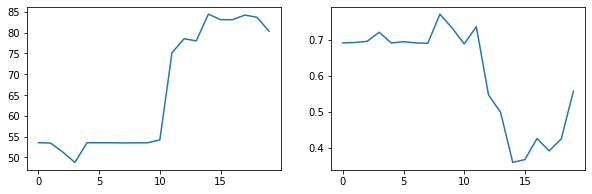

In [12]:
import matplotlib.pyplot as plt
print(model_epoch_list)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(acc_epoch_list)
plt.subplot(1,2,2)
plt.plot(loss_epoch_list)

In [16]:
save_json(ROBOT_TYPE_NAME+".json", {"epoch": np.array(model_epoch_list), "acc": np.array(acc_epoch_list), "loss": np.array(loss_epoch_list)})

In [ ]:
# data_path = dataset_train[0]
# full_data = load_pickle(data_path)
# full_tar_idx = full_data[b'tar']
# full_tool_idx = full_data[b'tool']
# save_json("tool.json", np.array(np.unravel_index(full_tool_idx, shape=FULL_SHAPE)).transpose())
# save_json("tar.json", np.array(np.unravel_index(full_tar_idx, shape=FULL_SHAPE)).transpose())